# Installing, Importing and Helper functions



In [1]:
!pip install findiff
!pip install gpytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 361 kB 8.7 MB/s 


In [2]:
import findiff
from findiff import FinDiff
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
from findiff import FinDiff, PDE, BoundaryConditions, Coef
from findiff.diff import Id
import scipy.ndimage
from scipy.sparse.linalg import eigs as find_eigs
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigsh
import matplotlib.image as mpimg


%matplotlib inline
%load_ext autoreload
%autoreload 2

##Helper Functions

In [3]:
def delete(arr: torch.Tensor, ind: int, dim: int) -> torch.Tensor:
    skip = [i for i in range(arr.size(dim)) if i != ind]
    indices = [slice(None) if i != dim else skip for i in range(arr.ndim)]
    return arr.__getitem__(indices)

def insert(arr: torch.Tensor, insert: torch.Tensor, ind: int, dim: int) -> torch.Tensor:
    if ind > 0:
        before_ind = [i for i in range(arr.size(dim)) if i < ind]
        before_indices = [slice(None) if i != dim else before_ind for i in range(arr.ndim)]
        before_arr = arr[before_indices]
        result = torch.cat((before_arr, insert))
    else:
        if insert.dim() < 1:
            insert = torch.tensor([insert])
        result = insert

    if ind < arr.size(dim) -1:
        after_ind = [i for i in range(arr.size(dim)) if i >= ind]
        after_indices = [slice(None) if i != dim else after_ind for i in range(arr.ndim)]
        after_arr = arr[after_indices]
        result = torch.cat((result, after_arr))
    
    return result 

def restricted_evec_problem(A, conditions):
    '''
    return the eigenvectors which satisfy a given condition. 
    
    parameters
    ----------
    A           np.array, A.shape = (n,n)
                the matrix whose restricted eigenvalues we are
                trying to find.
    conditions  np.array, conditions.shape = (m,n+1)
                the set of restrictions our eigenvalues must have.
                for each of the m conditions:
                write the restriction in the following form:
                a_1 v_1 + a_2 v_2 + ... + a_n v_n + c = 0
                then input a line of the conditions matrix:
                [a_1, a_2, ..., a_n, c]
    '''
    n = A.shape[0]
    eigenvectors = []
    eigenvalues = []
    
    # factor out c from the conditions
    
    # our target is the first non-zero entry of the condition
    target = np.where(conditions[0] != 0)[0][0]
    
    # creating the reformed A matrix
    A_1 = np.delete(A, target, axis=0)
    A_1 = np.delete(A_1, target, axis=1)
    # a vector from the target column of the A matrix
    a = np.delete(A[:,target], target)
    # b vector in the form v_target = sum of b_i v_i
    b = np.delete(conditions[0][:-1], target) * -1 / conditions[0][target]
    A_1 += np.outer(a, b)
    
    mini_evals, mini_evecs = np.linalg.eig(A_1)
    
    for i in range(n-1):
        evec = np.insert(mini_evecs[:,i], target, np.sum(b * mini_evecs[:,i]))
        if np.abs(A[target,:] @ evec - mini_evals[i] * np.sum(b * mini_evecs[:,i])) < 1e-9:
            eigenvectors.append(evec)
            eigenvalues.append(mini_evals[i])
            
    return eigenvectors, eigenvalues

#Helper functions
def make_big_d(start, end, step_count):
    step_size = (end - start)/step_count
    return torch.linspace(start - step_size, end+step_size, step_count + 2)


def make_laplace_1d(shape : tuple, dt : float, do_assist = False):
    '''
    This just approximates the laplacian in 1 dimension in matrix form using a stencil matrix
    
    '''
    if not isinstance(shape, tuple):
        shape = (shape[0], shape[0])
    assert shape[0] >=4, "Cannot do less than 4x4 apparently"
    
    L = FinDiff(0,dt,2)
    #I do shape + 2 in order to make the rectangle boundary one larger in each direction
    if do_assist:
        return L.stencil(shape = (np.max(shape)+2, np.max(shape) + 2)).apply_all(np.eye(np.max(shape)+2))
    else:
        return L.stencil(shape = (np.max(shape), np.max(shape))).apply_all(np.eye(np.max(shape)))


def make_laplace_2D(shape : tuple, dt : float, do_assist = False):
    if not isinstance(shape, tuple):
        shape = (shape[0], shape[0])
    assert shape[0] >=4, "Cannot do less than 4x4 apparently"
    
    L = FinDiff(0,dt,2) + FinDiff(1, dt, 2)
    #I do shape + 2 in order to make the rectangle boundary one larger in each direction
    if do_assist:
        return L.stencil(shape = (np.max(shape)+2, np.max(shape) + 2)).apply_all(np.eye(np.max(shape)+2))
    else:
        return L.stencil(shape = (np.max(shape), np.max(shape) )).apply_all(np.eye(np.max(shape)**2))


def apply_laplacian_2D(dx, dy, shape):
    L = findiff.Laplacian(h=[dx, dy])
    return L(np.eye(shape))


def make_mask(image_path):
    im = mpimg.imread(image_path)

    # Resize
    im = scipy.ndimage.zoom(im, 0.3125, order=2)

    # Convert to mask
    foo = np.amax(im[:,:,:2],2)<0.5

    # Pad boundary
    mask = np.zeros((foo.shape[0]+2,foo.shape[1]+2),dtype=bool)
    mask[1:-1,1:-1] = foo

    return mask

class SolinDomain():
    def __init__(self, ms : int = 32, xlim : tuple = (0,1), 
                 ylim : tuple = (0,1), image_path = None,
                 mask = None, neumann = None):
        """
        params
        ms : number of basis functions (int)
        image : path
        """

        self.ms = ms
        self.xlim = xlim
        self.ylim = ylim

        if image_path:
            self.mask = make_mask(image_path)
        elif mask is not None:
            self.mask = mask

        
        if neumann is None:
            self.make_laplace_2D()
        else:
            self.make_laplace_2D_neumann(neumann)
        self.get_eigenvalues()

    def make_laplace_2D(self):
        """
        Description:
        Make domain from mask of image.
        Where mask of image is 
            np.amax(im[:,:,:2],2)<0.5
        # Pad boundary
        mask = np.zeros((foo.shape[0]+2,foo.shape[1]+2),dtype=bool)
        mask[1:-1,1:-1] = foo

        Params:
        mask: np.amax(im[:,:,:2],2)<0.5, 
        xlim : tuple of (start, stop) for x
        ylim : tuple of (start, stop) for y
        m : number of basis functions to use

        Returns: None
        But stores eigenvalues and eigenfunctions
        """

        # Assert that the mask represents a square area
        assert self.mask.shape[0]==self.mask.shape[1]
        assert self.xlim==self.ylim

        # Composition of the stencil matrix is based on the 9-point rule
        I,J = np.where(self.mask);

        # Values for constructing sparse array
        row = np.array(1);
        col = np.array(1);
        val = np.array(1);

        # Define the operator
        OP = np.array([[1/6,2/3,1/6],[2/3,-10/3,2/3],[1/6,2/3,1/6]])

        for k in range(0,len(I)):
            for di in [-1,0,1]:
                for dj in [-1,0,1]:
                    i = np.where((I==I[k]+di) & (J==J[k]+dj))
                    row = np.append(row,k*np.ones(i[0].shape))
                    col = np.append(col,i[0])
                    val = np.append(val,OP[di+1,dj+1]*np.ones(i[0].shape))

        # Discard placeholders
        row = row[1:]
        col = col[1:]
        val = val[1:]

        # Scale by step size
        h = (self.xlim[1]-self.xlim[0])/(self.mask.shape[1]+1)
        val /= h**2

        # Construct the stencil matrix
        S_h = coo_matrix((val, (row, col)), shape=(len(I), len(I)))
        self.S_h = S_h
        self.h = h
        self.mu, self.V = eigsh(self.S_h, self.ms, which = 'LA')

    def make_laplace_2D_neumann(self, neumann = np.array([1,0,1,0])):    

        """
        Description:
        Make domain from mask of image.
        Where mask of image is 
            np.amax(im[:,:,:2],2)<0.5
        # Pad boundary
        mask = np.zeros((foo.shape[0]+2,foo.shape[1]+2),dtype=bool)
        mask[1:-1,1:-1] = foo

        Params:
        mask: np.amax(im[:,:,:2],2)<0.5, 
        xlim : tuple of (start, stop) for x
        ylim : tuple of (start, stop) for y
        m : number of basis functions to use

        Returns: None
        But stores eigenvalues and eigenfunctions
        """

        # Assert that the mask represents a square area
        assert self.mask.shape[0]==self.mask.shape[1]
        assert self.xlim==self.ylim

        # Composition of the stencil matrix is based on the 9-point rule
        I,J = np.where(self.mask);

        interior_row = I
        interior_col = J[0]
        # Values for constructing sparse array
        row = np.array([1]);
        col = np.array([1]);
        val = np.array([1]);

        # We need to modify the values at the interior. If neumann we have interior = exterior, so then val_int = val_int + val_ext

        # Define the operator
        OP = np.array([[1/6,2/3,1/6],[2/3,-10/3,2/3],[1/6,2/3,1/6]])

        to_add = 0

        #These are the corresponding INDICES of the rows, not the actual rows themselves
        exterior_row_ind = []
        interior_row_ind = []
        for k in range(0,len(I)):
            for di in [-1,0,1]:
                for dj in [-1,0,1]:
                    #This is where there are ones in some direction
                    i = np.where((I==I[k]+di) & (J==J[k]+dj))
                    row = np.append(row,k*np.ones(i[0].shape))
                    col = np.append(col,i[0])
                    val = np.append(val,OP[di+1,dj+1]*np.ones(i[0].shape))
                                        # Check if its on the boundary
                    dx_int = False
                    dx_ext = False
                    i = np.where((I==I[k]+di) & (J==J[k]+dj))
                    row = np.append(row,k*np.ones(i[0].shape))
                    col = np.append(col,i[0])
                    val = np.append(val,OP[di+1,dj+1]*np.ones(i[0].shape))
                                    # Check if its on the boundary
                    dx_int = False
                    dx_ext = False
                    if ((di != 0 and dj == 0) or (dj != 0 and di == 0)) and i[0].size > 0:
                        # This also counts as an exterior (if it is on the boundary):
                        if dj == 0:
                            if  self.mask.shape[0] - 1 < I[k] + 2*di or 0 > I[k] + 2*di:
                                dx_ext = True
                            else:
                                dx_ext = (self.mask[I[k] + 2*di, J[k]] == 0)
                        if di == 0:
                            if  self.mask.shape[1] - 1 < J[k] + 2*dj or 0 > J[k] + 2*dj:
                                dy_ext = True
                            else:
                                dy_ext = (self.mask[I[k], J[k] + 2*dj] == 0)
                        
                        #up/down direction
                        if di == -1:
                            #Bottom
                            if dx_ext and neumann[0] == 1:
                                exterior_row_ind.append(int(i[0][0]))
                                #ir = interior row index
                                ir = np.where((I == I[k] - di)& (J==J[k] - dj))[0]
                                if ir.size > 0:
                                    ir = int(ir[0])
                                else:
                                    ir = None
                                interior_row_ind.append(ir)
                        elif di == 1:
                            if dx_ext and neumann[1] == 1:
                                exterior_row_ind.append(int(i[0][0]))
                                #ir = interior row index
                                ir = np.where((I == I[k] - di) & (J==J[k] - dj))[0]
                                if ir.size > 0:
                                    ir = int(ir[0])
                                else:
                                    ir = None
                                interior_row_ind.append(ir)
                        #left/right direction
                        elif dj == -1:
                            #
                            if neumann[2] == 1 and dy_ext:
                                exterior_row_ind.append(int(i[0][0]))
                                #ir = interior row index
                                ir = np.where((I == I[k] - di)& (J==J[k] - dj))[0]
                                if ir.size > 0:
                                    ir = int(ir[0])
                                else:
                                    ir = None
                                interior_row_ind.append(ir)
                        elif dj == 1:       
                            if neumann[3] == 1 and dy_ext:
                                exterior_row_ind.append(int(i[0][0]))
                                #ir = interior row index
                                ir = np.where((I == I[k] - di)& (J==J[k] - dj))[0]
                                if ir.size > 0:
                                    ir = int(ir[0])
                                else:
                                    ir = None
                                interior_row_ind.append(ir)

        true_interior_row_ind = list(set(interior_row_ind) - set(exterior_row_ind))

        exterior_row_ind = np.array(exterior_row_ind)
        interior_row_ind = np.array(interior_row_ind)

        #Delete placeholders, they are just here to make dtype int
        row = row[1:];
        col = col[1:];
        val = val[1:];


        #rows_to_delete == col_to_delete
        if len(exterior_row_ind) > 0:
            val = neumann_laplace(row, col, val, interior_row_ind, exterior_row_ind, I)
        
        #offset is just needed in order to make insertions easier later
        res_row, res_col, res_val, offset = del_elems(row, col, val, exterior_row_ind)

        # Construct the stencil matrix
        
        if exterior_row_ind.size > 0:
            exterior_rows = np.unique(exterior_row_ind)
            S_h = coo_matrix((res_val, (res_row, res_col)), shape=(len(I) - len(exterior_rows), len(I) - len(exterior_rows)))
        else:
            S_h = coo_matrix((val, (row, col)), shape=(len(I), len(I)))
        
        h = (self.xlim[1]-self.xlim[0])/(self.mask.shape[1]+1)
        val /= h**2
        # Construct the stencil matrix
        self.S_h = S_h
        self.h = h

        self.mu, res_evecs = eigsh(S_h, self.ms, which = 'LA')

        if exterior_row_ind.size > 0:
            self.V = recover_eigenvec(res_evecs, interior_row_ind, exterior_row_ind, len(I))
        else:
            self.V = res_evecs
    
    def get_eigenvalues(self):
        # Solve eigenvalue problem
        mu,V = self.mu, self.V

        # Better approximations of the eigenvalues
        self.hlambda = np.flipud(2*mu / (np.sqrt(1 + mu*self.h**2/3) + 1));

        # Address scaling issues
        V = V * 1/self.h;

            # Expand size to match self.mask
        Vsquare = np.zeros((self.mask.shape[0]*self.mask.shape[1],self.ms))
        ind, = np.where(self.mask.flatten())
        for i in range(len(ind)):
            Vsquare[ind[i],:] = V[i,:]

        # Store eigenvectors and self.mask
        self.V = np.fliplr(Vsquare)
        
        self.x1 = np.linspace(self.xlim[0],self.xlim[1],self.mask.shape[1])
        self.x2 = np.linspace(self.ylim[0],self.ylim[1],self.mask.shape[0])
    
    def eigenfun(self,x):
        """
        Evaluate eigenfunctions.
        """
        foo = self.V.reshape((self.mask.shape[0],self.mask.shape[1],self.ms))
        U = np.zeros((x.shape[0],self.ms))
        for k in range(x.shape[0]):
            i = np.abs(self.x1-x[k,0]).argmin()
            j = np.abs(self.x2-x[k,1]).argmin()
            U[k,:] = foo[j,i,:].flatten()
        return U

def del_elems(rows, cols, vals, rows_to_del):
    rows_old = rows.copy()
    if rows_to_del.size < 1 :
        return rows, cols, vals, rows_old
    
    rix_to_del = np.array([1])
    cix_to_del = np.array([1])
    for i in range(len(rows_to_del)):
        rix = np.where(rows == rows_to_del[i])[0]
        cix = np.where(cols == rows_to_del[i])[0]
        rix_to_del = np.append(rix_to_del, rix)
        cix_to_del = np.append(cix_to_del, cix)
    
    rix_to_del = np.unique(rix_to_del[1:])
    cix_to_del = np.unique(cix_to_del[1:])
    ix_to_del = np.unique(np.append(rix_to_del, cix_to_del))
    #row indices sorted
    rix_sorted = np.argsort(rows)
    cix_sorted = np.argsort(cols)
    i = 0
    
    #Counter for number of rows and columns deleted thus far
    rkill = 0
    ckill = 0
    old_row = -1
    old_col = -1

    for i in range(len(rows)):
        r_ix = rix_sorted[i]
        if r_ix in rix_to_del and rows[r_ix] != old_row:
            rkill +=1
            old_row = rows[r_ix]
            rows[r_ix] -= rkill
        else:
            rows[r_ix] -= rkill

        c_ix = cix_sorted[i]
        if c_ix in cix_to_del and cols[c_ix] != old_col:
            ckill +=1
            old_col = cols[c_ix]
        else:
            cols[c_ix] -= ckill
    
    offset = (rows_old - rows).astype(int)
    cols = np.delete(cols, ix_to_del)
    rows = np.delete(rows, ix_to_del)
    vals = np.delete(vals, ix_to_del)
    return rows, cols, vals, offset

def recover_eigenvec(eigenvecs, rows_int, rows_ext, total_rows):
    new_e = np.zeros((total_rows, eigenvecs.shape[1]))
    ix_non_ext = np.ones(total_rows, dtype = bool)
    ix_non_ext[rows_ext] = False
    new_e[ix_non_ext, :] = eigenvecs
    new_e[rows_ext,:] = new_e[rows_int,:]
    return new_e

## We need to take every reference to the exterior, and make it point to the interior
def neumann_laplace(rows, cols, vals, int_rows, ext_rows,I):
    for k in range(len(I)):
        for j in range(len(ext_rows)):
            ext_row = np.where((rows == k) & (cols == ext_rows[j]))[0]
            int_row = np.where((rows == k) & (cols == int_rows[j]))[0]
            if int_row.size > 0 and ext_row.size > 0:
                vals[int(int_row[0])] += vals[int(ext_row[0])]
    return vals


In [4]:
def make_rectangle(size : np.array, with_pad = True):
    zeros = np.zeros(size + int(with_pad)*np.array([2,2]))
    ones = np.ones(size)
    if with_pad:
        zeros[1:-1,1:-1] = ones
    else:
        zeros = ones
    return zeros
    
mask3 = make_rectangle(np.array([100,100]))

###Useful Code

In [111]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

def plot(observed_pred, train_x, train_y, test_x=torch.linspace(0, 5/2*torch.pi, 300), true_func = None, mean_adjustment = 0, y_lim = None, save_name = 'matern_toy.png', with_samples = True):

    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(1, 1, figsize=(9, 6))

        # Get upper and lower confidence bounds, given by 2std below and above respectively
        lower, upper = observed_pred.confidence_region()
        # Plot training data as black stars
        ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), observed_pred.mean.numpy() + mean_adjustment, '--')
        
        if with_samples:
            samples = observed_pred.sample(torch.Size([3]))
            for sample in samples:
                ax.plot(test_x.numpy(), sample.numpy(), color = 'orange')
        if true_func is not None:
            # Plot true function if exists
            ax.plot(test_x.numpy(), true_func, 'green')
        plt.suptitle(r'$\frac{7}{2}$ Matern Regression', fontsize = 20)
        ax.set_xlabel('x', fontsize = 16)
        ax.set_ylabel('$p(f(\cdot) | y, X)$', fontsize = 16)
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower.numpy() + mean_adjustment, upper.numpy() + mean_adjustment, alpha=0.5)
        ax.grid(True)
        ax.set_ylim([-4, 4] if y_lim is None else y_lim)
        if true_func is not None and not with_samples:
            legend = ['Observed Data', 'Mean', 'True function', 'Confidence'] 
        elif with_samples and true_func is not None:
            legend = ['Observed Data', 'GP Mean', 'Sample 1', 'Sample 2', 'Sample 3', 'True Func', 'Confidence']
        elif with_samples:
            legend = ['Observed Data', 'GP Mean', 'Sample 1', 'Sample 2', 'Sample 3', 'Confidence']
        else:
            legend = ['Observed Data', 'GP Mean', 'True Func', 'Confidence']

        ax.legend(legend)
        plt.savefig(save_name)
    
# Wrap training, prediction and plotting from the ExactGP-Tutorial into a function, 
# so that we do not have to repeat the code later on
def train(model, train_x, train_y, likelihood, training_iter=training_iter, verbose = True):
   # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = likelihood(model(train_x))
        
        
        
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        # loss.backward()
        loss.backward(retain_graph = True)
        if verbose:
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                i + 1, training_iter, loss.item(),
                model.covar_module.base_kernel.lengthscale.item(),
                model.likelihood.noise.item()
            ))
        optimizer.step()

def predict(model, likelihood, test_x = torch.linspace(0, 1, 51)):
    model.eval()
    likelihood.eval()
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Test points are regularly spaced along [0,1]
        return likelihood(model(test_x))


In [6]:
mt = make_rectangle(np.array([20,20]), with_pad = True)

dm = SolinDomain(ms = 10, mask = mt, neumann = [1,1,0,0])
dm2 =  SolinDomain(ms = 10, mask = mt, neumann = None)

###Possibly Useless Code

# Playing around with Solin

In [7]:
! git clone https://github.com/AaltoML/boundary-gp.git

Cloning into 'boundary-gp'...
remote: Enumerating objects: 75, done.
remote: Total 75 (delta 0), reused 0 (delta 0), pack-reused 75
Unpacking objects: 100% (75/75), done.


In [8]:
import os
print(os.getcwd())
if not 'star.png' in os.listdir():
    os.chdir('/content/boundary-gp/python/examples/domain/')

# solin = SolinDomain(image_path = 'star.png', neumann = [1,0,1,0])



/content


In [9]:
def eigenfun(solin,x):
    """
    Evaluate eigenfunctions.
    """
    foo = solin.V.reshape((solin.mask.shape[0],solin.mask.shape[1],solin.ms))
    U = np.zeros((x.shape[0], solin.ms))
    for k in range(x.shape[0]):
        i = np.abs(solin.x1-x[k,0]).argmin()
        j = np.abs(solin.x2-x[k,1]).argmin()
        U[k,:] = foo[j,i,:].flatten()
    return U

X1, X2 = np.mgrid[0:1:100j, 0:1:100j]
XT = np.vstack((X1.flatten(), X2.flatten())).T

# Evaluate basis functions at test inputs
V = eigenfun(solin, XT)

# Visualize the basis functions (color scale arbitrary)
fig, axs = plt.subplots(4,8, figsize=(10, 4))
axs = axs.ravel()
for j in range(solin.ms):
    ind = V[:,j]==0
    V[ind,j]=float('NaN')
    axs[j].pcolormesh(X1, X2, V[:,j].reshape(100, 100))
    axs[j].set_title(str(j))
    axs[j].axis('equal')
    axs[j].axis('off')

NameError: ignored

# Setting up 1-D problem

The below just sets up a problem to be solved. In this case the problem is solving the PDE given by 

$u''(t) = sin(t) \\
: t \in [0,1]$

And we solve this using a finite difference method, with a step size of $\frac{1}{300}$



In [177]:
'''
Define the test problem below
'''

shape = (300, )
t = np.linspace(0, 5/2*np.pi, shape[0])
dt = t[1]-t[0]

ALPHA = 3
OMEGA = 2
LAMBDA = 0

laplace_1d = FinDiff(0,dt,2)

# L = FinDiff(0, dt, 2) - Coef(ALPHA)*FinDiff(0, dt, 1) + Coef(OMEGA**2)*Id()

#The true function
f = np.sin(t)

#Add some boundary conditions
bc = BoundaryConditions(shape)
bc[0] = 5
# bc[0] = FinDiff(0, dt, 1), 0

#If you dont give it boundary condition at t[-1] it breaks for some reason :S
bc[-1] = -np.sin(t[-1]) + 5
# bc[-2] = FinDiff(0, dt, 1), 0

#Solve the PDE using a solver (although I would have assumed the answer to just be -np.sin(t))
pde = PDE(laplace_1d, f, bc)
#Store the solution in u_true
u_true = pde.solve()

#Find the eigenvectors and eigenvalues of the laplacian
lapl_mat = make_laplace_1d(shape, dt)
lapl_res = lapl_mat[1:,1:]
lam_res, u_res = find_eigs(lapl_res)

# stencil = laplace_2d.stencil(u.shape)
# This here seems useless atm idk
# print(len(stencil.data))

#This gives a the stencil I'm looking for similar to the paper
# print(stencil.apply_all(u)/324)



In [86]:
lapl_mat*(dt**2)

array([[ 2., -5.,  4., ...,  0.,  0.,  0.],
       [ 1., -2.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1., -2., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -2.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1., -2.,  1.],
       [ 0.,  0.,  0., ...,  4., -5.,  2.]])

(300, 300)


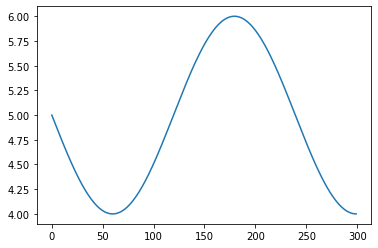

In [178]:
plt.plot(u_true)

print(lapl_mat.shape)

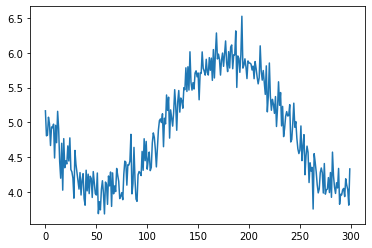

In [179]:
y = u_true + 0.2*np.random.normal(size = shape)
plt.plot(y)

In [180]:
#Choosing samples
sample_indices = np.random.choice(np.arange(0,shape[0]), size = 20)
# sample_indices = np.arange(50)
train_x = torch.Tensor(t[sample_indices])
# True function is -sin(x) with Gaussian noise? I wouldve assumed
y_train = y
train_y = torch.Tensor(y_train[sample_indices])

# Fitting a standard matern gp

And also adding some helper functions




In [89]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel = None, mean = None, has_noise = True, is_zero_mean = False, has_mean_adjustment = True):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.base_kernel = None
        self.has_mean_adjustment = has_mean_adjustment if kernel is not None else False
        if kernel is not None:
            self.base_kernel = kernel
            self.scale_kernel = gpytorch.kernels.ScaleKernel(kernel)
        #No kernel function, no mean function (ie baseline)
        if mean is None and kernel is None:
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())
            self.mean_module = gpytorch.means.ConstantMean() if not is_zero_mean else gpytorch.means.ZeroMean()

        #Kernel supplied, but no mean function
        elif mean is None:
            self.covar_module = self.scale_kernel
            self.mean_module = gpytorch.means.ConstantMean() if not is_zero_mean else gpytorch.means.ZeroMean()
        
        #Kernel and mean function is supplied
        else:
            self.covar_module = self.scale_kernel
            self.mean_module = mean

        if not has_noise:
            # Assume: likelihood noise constraint was defined so that 1e-4 is within range.
            self.likelihood.noise = 1e-4  # Some small value, but don't make it too small or numerical performance will suffer. I recommend 1e-4.
            self.likelihood.noise_covar.raw_noise.requires_grad_(False)  # Mark that we don't want to train the noise.
    
    def forward(self, x):
        covar_x = self.covar_module(x)
        if self.has_mean_adjustment:
            mean_x = self.mean_module(x, self.base_kernel.mean_adjustment)
        else:
            mean_x = self.mean_module(x)

        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


class KernelMean(gpytorch.means.mean.Mean):
    def __init__(self, domain, batch_shape = torch.Size(), **kwargs):
        super(KernelMean, self).__init__()
        self.batch_shape = batch_shape
        self.domain = domain

    def __call__(self, input, mean_adjustment):
        return self.forward(input, mean_adjustment)

    def forward(self, input, mean_adjustment):
        mean = mean_adjustment
        indices = self.convert_to_index(input)
        return mean[indices]

        
    def convert_to_index(self, input):
        ind_x1 = []
        for xi in input.flatten():
            ix_x1 = torch.where(torch.abs(torch.abs(self.domain - xi) - torch.abs(self.domain - xi).min()) < 1e-6)
            ind_x1.append(ix_x1[0])
            if len(ix_x1[0]) > 1:
                print("Warning! multiple matches found for domain should not happen!")
        
        ind_x1 = torch.concat(ind_x1)
        return ind_x1


# Trying to implement Boundary Complacent GPs

This includes 2 classes:


1.   Boundary Class - Helps create the appropriate laplacian for different kinds of boundary conditions
2.   Custom Kernel that takes boundary objects as arguments and fits according to Solin paper

Alert! Doesnt actually work very well



In [90]:
#Simple first order boundary approx
class Boundary():
    def __init__(self, kind : str = 'neumann', indices : list = [(0, slice(None)), (2, slice(None))],
        values : torch.Tensor = torch.Tensor([-1,1]), deriv : float = 0, step_size : float = 0.01,
        constants = None):
        '''
        Creates a neumann or dirichlet boundary condition object

        Args:
        kind: Kind/type of boundary condition (either neumman or dirichlet).

        indexes: List of indices in which the relation holds. For dirichlet this is typically integer indices, 
        for neumann typically slice indices. 

        values: List of floats such that torch.dot(indices, values) / 2h == deriv. See example for further clarity.

        deriv: Float such that np.dot(indices, values) / 2h == deriv. See example for further clarity.

        Returns:
        This is a description of what is returned.

        Example:
        Function f : (x,y) -> z and Neumann condition df/dx(0,y) = 0.
        Domain is [-0.1 : 1.0 : 101]^2 i.e [-0.01, 0.00, 0.01, 0.02, ...] ^ 2
        (So in the finite difference world we have h = 0.01)
        The corresponding indexes should be [[0, slice(None)], [2, slice(None)]]
        The corresponding values should be [-1,1]
        The corresponding offset should be 0
        This indicates that (f[.01,y] - f[-0.01,y])/2h = 0


        Raises:
        KeyError: Raises an exception.
        '''
        self.kind = kind
        self.indices = indices

        self._values = values
        self.step_size = step_size
        if constants is None:
            self.constants = -2 * step_size * deriv
        else:
            self.constants = constants
        
        #Right_vec is used for solving the particular solution
        self.right_vec = None
        self.mean_adjustment = 0

    #For neumann only   
    def restrict_laplacian(self, l_mat : torch.Tensor, domain : torch.Tensor, lengthscale, dirichlet = False, right_vec = None, 
                           L_particular = None, nu = None):
        """
        Takes Laplacian Matrix L and incorporates constraints
        
        
        Let c be number of constraints
        
        Does so by creating matrix B (n-c) x (n-c) from the corresponding columns of matrix L
        """
        
        
        n = domain.flatten().shape[0]
        
        index_matrix = torch.arange(n).view(domain.shape)
        
        left_ind = index_matrix[self.indices[0]]
        
        right_ind = index_matrix[self.indices[1]]

        if dirichlet:
            #reset the matrix to only be one diagonal entry for dirichlet
            # assert (l_res == l_mat[1:-1,1:-1]).all()
            rows_to_delete = [x for x in range(n) if x in left_ind or x in right_ind]
            # return l_mat[1:-1,1:-1]
            #Find the correct mean adjustment whilst at it
            self.adjust_right_vec(l_mat, domain, lengthscale, dirichlet, right_vec, L_particular, nu)
            return l_mat, rows_to_delete

        #Correct value indices now we know domain
        self.values = torch.zeros_like(domain).flatten()

        self.values[left_ind] = self._values[0] 
        self.values[right_ind] = self._values[1]
                        
        #Find the relevant columns in the laplace matrix
        b_mat = l_mat[:, left_ind]
        
        
        #Multiply these columns by the vector of values in the constraint and deriv * 2h
        #Note, I have not deleted any row yet
        b_mat = b_mat * self._values[1]

        l_mat[:, right_ind] = l_mat[:, right_ind] + b_mat

        #Delete the rows corresponding to the columns we extracted
        row_selector = [x for x in range(n) if x not in left_ind]
                
        l_res = l_mat[row_selector][:, row_selector]

        rows_to_delete = left_ind

        assert l_res.shape[0] == l_res.shape[1], l_res.shape

        self.adjust_right_vec(l_mat, domain, lengthscale, dirichlet, right_vec, L_particular, nu)

        return l_mat, rows_to_delete
    
    def fill_u(self, u_res, domain, l_mat = None, dirichlet = False, mean_adjustment = None, row_selector = None):

        # foo = torch.zeros_like(u_res)
        # bar = torch.zeros(u_res.shape[0]).view(1,-1)
        n = domain.flatten().shape[0]
        index_matrix = torch.arange(n).view(domain.shape)
        left_ind = index_matrix[self.indices[0]]
        right_ind = index_matrix[self.indices[1]]

        u_filled = torch.zeros((domain.shape[0], u_res.shape[1]), dtype = torch.cdouble)

        #Dirichlet
        if dirichlet:
            #Need to fill in both left and right indices
            #Row_selector will be passed in instead (at least for dirichlet)
            # foo = (u_filled.shape[0] - u_res.shape[0])//2
            # u_filled[foo:-foo, foo:-foo] = u_res.clone()
            u_filled = u_res.clone()
            zeros = torch.zeros(u_filled.shape[1], dtype = torch.cdouble).view(1, -1)
            u_filled = insert(u_filled, zeros, 0, 0)
            u_filled = insert(u_filled, zeros, u_res.shape[0] - 1, 0)
            rows_to_add = []
            if hasattr(left_ind.tolist(), '__iter__'):
                rows_to_add.extend(left_ind.tolist())
            else:
                rows_to_add.append(left_ind.tolist())
            if hasattr(right_ind.tolist(), '__iter__'):
                rows_to_add.extend(right_ind.tolist())
            else:
                rows_to_add.append(right_ind.tolist())
            return u_filled, rows_to_add
        
        #Neumann
        row_selector = [x for x in range(u_filled.shape[0]) if x not in left_ind] if row_selector is None else row_selector
        u_filled[row_selector] = u_res

        u_filled[self.indices[0]] = ((self.values[1:].view(-1,1) * u_filled[self.indices[1:]].view(1,-1)).sum(axis=0)).view(1,-1)

        assert (u_filled[0] - u_filled[2] == 0).all()
        
        return u_filled

    def adjust_right_vec(self, l_mat, domain, lengthscale, dirichlet = False, right_vec = None, L_particular = None, nu = 3/2):
        """
        Remember neumann needs to be solved on l_res, whereas
        dirichlet needs to be solved on l_mat
        """
        
        
        n = domain.flatten().shape[0]
        index_matrix = torch.arange(n).view(domain.shape)
        
        
        if right_vec is None:
            right_vec = torch.zeros(l_mat.shape[0])
            right_vec2 = torch.zeros(l_mat.shape[0])
        else:
            right_vec2 = right_vec

        l_new = l_mat.clone().float() if L_particular is None else L_particular

        if dirichlet:
            #Find the relevant columns in the laplace matrix
            all_indices = []
            for i in range(len(self.indices)):
                indices = index_matrix[self.indices[i]]
            #     b = l_mat[:, indices]
            #     right_vec = right_vec  - b * self.constants[i]
                all_indices.extend([indices.numpy()])
            
            row_selector = [i for i in range(n) if i not in all_indices]
            #This is a smaller matrix, such that when solved, needs to be filled in with more entries
            # right_vec = right_vec[row_selector]
            
           
            for i in range(len(self.indices)):
                indices = index_matrix[self.indices[i]]
                right_vec2[indices] = self.constants[i]
                l_new[indices] = l_new[indices]*0
                l_new[indices, indices] = 1

            #I detach the gradient from the lengthscale, it is not exactly correct but will be too much work trying to get it to work
            l = lengthscale.clone().detach()
            l_new[row_selector] = 2*nu / (l **2)  + l_new[row_selector]
            sol = torch.linalg.solve(l_new, right_vec2)
            self.mean_adjustment = sol
            self.right_vec = right_vec2


        
        #Neumann needs to be adjusted for general case data struct
        else:
            left_ind = index_matrix[self.indices[0]]
            right_ind = index_matrix[self.indices[1]]
            # b = l_mat[:, right_ind]
            # right_vec = right_vec - b* self.constants
            
            #self.constants should be derivative scalar
            right_vec2[left_ind] = self.constants
            l_new[left_ind] = l_new[left_ind]*0
            #u[0] - u[2] = k
            l_new[left_ind, left_ind] = 1
            l_new[left_ind, right_ind] = -1
        
        self.L_particular = l_new
        self.right_vec = right_vec2



In [91]:
class BCKernel(gpytorch.kernels.Kernel):
    def __init__(self, domain, likelihood, dirichlet : list = None, neumann : list = None,
                 nu_prior = None, nu_constraint = None, big_domain = None,
                 **kwargs):
        
        """
        args:
        dirichlet/neumann are lists of Boundary objects
        """
        super().__init__(**kwargs)
        
        #Initialise for later
        self.mean_adjustment = None


        self.likelihood = likelihood
        self.domain = domain if torch.is_tensor(domain) else torch.as_tensor(domain)
        
        if big_domain is None:
            raise NotImplemented("currently need big_domain)")
        self.big_domain = big_domain
        
        #Only 2 dimension at the moment
        self.dimension = 1 if len(domain.shape) == 1 else domain.shape[0]
        self.nu = torch.tensor(2.5, requires_grad = True)
        
        # self._register_nu(nu_constraint, nu_prior)
        
        # Hard coded for now!! TODO: Make more general for more dimensions
        if self.dimension == 1:
            dt = domain[1] - domain[0]
            lapl_mat = make_laplace_1d(self.big_domain.shape, dt.item())
        elif self.dimension == 2:
            dx = domain[0, 1, 0] - domain[0, 0, 0]
            dy = domain[1, 0, 1] - domain[1, 0 , 0]
            lapl_mat = apply_laplacian_2D(dx, dy, max(domain.shape)**2)
        
        self.h = dt

        lapl_mat[0] = lapl_mat[1]
        #These are not important for any end computation, so just leave the outers as 1 on diagonal with zeros off diagonal
        lapl_mat[0] = 0 ; lapl_mat[0,0] = 1
        lapl_mat[-1] = lapl_mat[-2]
        #These are not important for any end computation, so just leave the outers as 1 on diagonal with zeros off diagonal
        lapl_mat[-1] = 0 ; lapl_mat[-1,-1] = 1
        self.L_full = -1 * lapl_mat
        rows_to_delete = set([0, lapl_mat.shape[0] -1 ])
        self.L = None
        right_vec = None
        L_particular = None
        
        if neumann is not None:
            for n in neumann:
                self.L = self.L_full if self.L is None else self.L_full
                self.L, more_rows_to_delete = n.restrict_laplacian(torch.tensor(self.L), self.big_domain, self.lengthscale, right_vec = right_vec, L_particular = L_particular, nu = self.nu,)
                rows_to_delete = rows_to_delete.union(set(more_rows_to_delete))
                right_vec = n.right_vec
                adjustment = n.mean_adjustment
                L_particular = n.L_particular
        if dirichlet is not None:
            for d in dirichlet:
                self.L = self.L_full if self.L is None else self.L
                self.L, more_rows_to_delete = d.restrict_laplacian(torch.tensor(self.L), self.big_domain, self.lengthscale, dirichlet = True, right_vec = right_vec, L_particular = L_particular, nu = self.nu)
                rows_to_delete = rows_to_delete.union(set(more_rows_to_delete))
                right_vec = d.right_vec
                adjustment = d.mean_adjustment
                L_particular = d.L_particular
            self.mean_adjustment = adjustment


        ## This is where the actual mean is found. Ignore all other parts in the code that has to do with mean adjustment (apart from right_vec, which is needed in the below method)
        ## I needed to detach gradient from l in order to avoid errors
        l = self.lengthscale.clone().detach()
        
        # Below produces an error
        # l = self.lengthscale
        # foo = 2*self.nu / (l **2)

        #If error arises, take the whole thing and turn it into a float
        # A = (foo) + (L_particular).float()
        self.mean_adjustment = torch.linalg.solve(L_particular.float(), right_vec)

        # Get the eigenvalues and eigenvectors of the restricted domain
        row_selector = [x for x in range(self.L.shape[0]) if x not in list(rows_to_delete)]
        self.L = self.L[row_selector][:, row_selector]
        # assert (self.L_tru == self.L).all()
        self.lam_res, self.u_res = torch.linalg.eig(torch.tensor(self.L))
        
        # Adjust eigenvalue matrix to account for whole big domain
        # foo = torch.zeros(self.big_domain.shape[0], dtype = torch.cdouble)
        # foo[row_selector] = self.lam_res
        # self.lam_full = foo
        self.lam_full = self.lam_res

        #Scaling issues addressed. I'm not sure what I'm doing but YOLO
        self.u_res/= self.h

        global debug_u_res
        debug_u_res = self.u_res
        
        #Correct eigenvalues from approximation
        # self.lam_full = torch.flipud(2*self.lam_full / (np.sqrt(1 + self.lam_full*self.h**2/3) + 1));

        if neumann is not None: 
            for n in neumann:
                self.u_full = n.fill_u(self.u_res, self.big_domain, row_selector = row_selector)
        else:
            self.u_full = self.u_res
                
        if dirichlet is not None:
            for d in dirichlet:
                self.u_full, rows_to_add = d.fill_u(self.u_res, self.big_domain, self.L, dirichlet = True, mean_adjustment = self.mean_adjustment, row_selector = row_selector)

    
    # the BCkernel is not stationary and has lengthscale
    # is_stationary = True
    has_lengthscale = True
    
    def forward(self, x1, x2, **params):
        spec_eigvals = self._compute_spectral(self.lam_full, **params)
        
        '''
        The below code just makes a vector of indices that correspond 
        to the correct eigenvectors from the domain
                            START [Unreasonable code]
        ---------------------------------------------------------------
        '''
        ind_x1 = []
        for xi in x1:
            ix_x1 = torch.where(torch.abs(torch.abs(self.domain - xi) - torch.abs(self.domain - xi).min()) < 1e-6)
            ind_x1.append(ix_x1[0])
            if len(ix_x1[0]) > 1:
                print("Warning! multiple matches found for domain should not happen!")
        
        ind_x2 = []
        for xi in x2:
            #TODO: Add optionality of adding indices instead, and change hardcoding to perhaps step_size/2 for 1e-6
            ix_x2 = torch.where(torch.abs(torch.abs(self.domain - xi) - torch.abs(self.domain - xi).min()) < 1e-6)
            ind_x2.append(ix_x2[0])
            if len(ix_x2[0]) > 1:
                print("Warning! multiple matches found for domain should not happen!")
        
        ind_x1 = torch.concat(ind_x1)
        ind_x2 = torch.concat(ind_x2)
        
        
        '''
                                END [Unreasonable code]
        ---------------------------------------------------------------
        '''
        
        #Use index in order to calculate \Phi.T \Lambda (diagonal eigenvalues) \Phi (eigenvector)
        #See equation (11) in KnowYourBoundaries.pdf

        big_lambda = spec_eigvals*torch.eye(spec_eigvals.flatten().shape[0])

        
        self.big_u_1 = self.u_full[ind_x1].clone().type(torch.complex128)
        self.big_u_2 = self.u_full[ind_x2].clone().type(torch.complex128)
        
        covar_matrix = ((self.big_u_1.conj() @ big_lambda.type(torch.complex128) @ self.big_u_2.T)).float()
        
        return covar_matrix
    
    def _compute_spectral(self, eigvals, **params):
        
        '''
        See equation (11) in KnowYourBoundaries.pdf
        '''
        d = self.dimension if torch.is_tensor(self.dimension) else torch.as_tensor(self.dimension)
        l = self.lengthscale
        v = self.nu


        log_gamma_term = torch.lgamma(v + d/2) - torch.lgamma(v)

        # const_term = 2**d * torch.pi ** (d/2) * (2*v)**v / l**(2*v)
        log_const_term = d*torch.log(torch.tensor([2])) + d/2 * torch.log(torch.tensor(torch.pi)) +  v * torch.log(2*v)  -  2*v*torch.log(l)
        
        # We take abs eigvals because the eigenvalues are meant to be positive if we had done the 
        # Negative laplacian instead of the laplacian as the matrix
        foo = (2*v/torch.pow(l,2) + torch.abs(eigvals))

        spectral = torch.exp(log_gamma_term + log_const_term ) * torch.pow((foo), -(2*v+d)/2)
        return spectral
    

        

In [92]:
from typing import Any

class DomainLikelihood(gpytorch.likelihoods.GaussianLikelihood):
    def __init__(self):
        super().__init__()
    
    def __call__(self, function_samples: torch.Tensor, *params: Any, **kwargs: Any):
        dist = self.forward(function_samples, *params, **kwargs)
        self._adjust_var(dist)
        return dist
    
    def _adjust_var(self, dist):
        dist.variance = torch.zeros_like(dist.variance)



#Train models on datapoints and fit

In [181]:
from numpy.core.numeric import indices

torch.autograd.set_detect_anomaly(True)

domain = torch.linspace(0, 5/2*torch.pi, shape[0])
big_domain = make_big_d(0,5/2*torch.pi,shape[0])
likelihood2 = gpytorch.likelihoods.GaussianLikelihood()
neumann_test = Boundary('neumann', [[0], [2]])
dirichlet_test = Boundary('dirichlet', [0, shape[0]], constants = [5, 5-torch.sin(torch.tensor(t[-1]))])
# dirichlet_test = Boundary('dirichlet', [0, shape[0] -1], constants = [0, 0])

bc_kernel = BCKernel(domain = domain, dirichlet = [dirichlet_test,], neumann = None, likelihood = likelihood2, big_domain = big_domain)
gp_mean = KernelMean(domain)
# bc_kernel = BCKernel(domain = domain, neumann = [neumann_test,], likelihood = likelihood2, big_domain = big_domain)
model2 = ExactGPModel(train_x, train_y, likelihood2, kernel = bc_kernel, mean = gp_mean)

print("-----------------------INITIAL PARAMS-------------------------")
for param_name, param in model2.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

print("--------------------------------------------------------------")
model2.train()
likelihood2.train()
train(model2, train_x, train_y, likelihood2, verbose = True)

print("----------------------TRAINED PARAMS----------------------------")
for param_name, param in model2.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')
print("-----------------------------------------------------------------")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


-----------------------INITIAL PARAMS-------------------------
Parameter name: likelihood.noise_covar.raw_noise           value = 0.0
Parameter name: base_kernel.raw_lengthscale                value = 0.0
Parameter name: scale_kernel.raw_outputscale               value = 0.0
--------------------------------------------------------------
Iter 1/50 - Loss: 2.041   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 1.977   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 1.914   lengthscale: 0.798   noise: 0.598
Iter 4/50 - Loss: 1.852   lengthscale: 0.854   noise: 0.554
Iter 5/50 - Loss: 1.791   lengthscale: 0.913   noise: 0.513
Iter 6/50 - Loss: 1.731   lengthscale: 0.973   noise: 0.473
Iter 7/50 - Loss: 1.672   lengthscale: 1.036   noise: 0.436
Iter 8/50 - Loss: 1.615   lengthscale: 1.100   noise: 0.402
Iter 9/50 - Loss: 1.560   lengthscale: 1.166   noise: 0.369
Iter 10/50 - Loss: 1.505   lengthscale: 1.234   noise: 0.338
Iter 11/50 - Loss: 1.452   lengthscale: 1.303   noise: 0.310

In [123]:
# test_x = torch.linspace(0,10,300)
# test_y = torch.sin(test_x) + 3/100* test_x**2 - 1/20 * test_x
# perm = torch.randperm(test_x.size(0))
# no_samples = 7
# idx = perm[:no_samples]
# train_x = test_x[idx]
# train_y = test_y[idx]

In [183]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood, is_zero_mean = False)
model.train()
likelihood.train()
train(model, train_x, train_y, likelihood, verbose = True)
model.eval()
likelihood.eval()
# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 5/2*torch.pi, 300)
    observed_pred = likelihood(model(test_x))
    observed_pred_clean = model(test_x)
print("----------------------TRAINED PARAMS----------------------------")
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')
print("-----------------------------------------------------------------")

Iter 1/50 - Loss: 3.772   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 3.453   lengthscale: 0.744   noise: 0.744
Iter 3/50 - Loss: 3.186   lengthscale: 0.798   noise: 0.796
Iter 4/50 - Loss: 2.963   lengthscale: 0.853   noise: 0.846
Iter 5/50 - Loss: 2.777   lengthscale: 0.909   noise: 0.890
Iter 6/50 - Loss: 2.620   lengthscale: 0.967   noise: 0.926
Iter 7/50 - Loss: 2.485   lengthscale: 1.026   noise: 0.951
Iter 8/50 - Loss: 2.368   lengthscale: 1.085   noise: 0.963
Iter 9/50 - Loss: 2.264   lengthscale: 1.144   noise: 0.962
Iter 10/50 - Loss: 2.171   lengthscale: 1.203   noise: 0.950
Iter 11/50 - Loss: 2.086   lengthscale: 1.262   noise: 0.929
Iter 12/50 - Loss: 2.007   lengthscale: 1.320   noise: 0.901
Iter 13/50 - Loss: 1.934   lengthscale: 1.378   noise: 0.867
Iter 14/50 - Loss: 1.866   lengthscale: 1.435   noise: 0.829
Iter 15/50 - Loss: 1.801   lengthscale: 1.491   noise: 0.787
Iter 16/50 - Loss: 1.740   lengthscale: 1.546   noise: 0.744
Iter 17/50 - Loss: 1.681   length

# Plot results


1.   Naive Matern GP
2.   Boundary incorporated Matern GP

You should expect to see points around the boundary to be better captured by second plot



##Naive Matern

/content


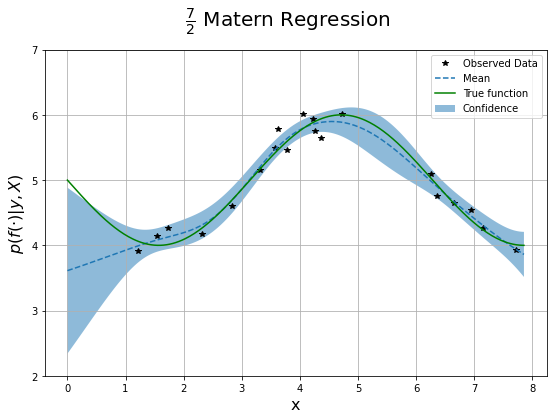

In [185]:
plot(observed_pred_clean, train_x, train_y, true_func = u_true, y_lim = [2,7], save_name = 'matern_const_dirichlet.png', with_samples = False)
print(os.getcwd())

In [190]:
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
metric = mll(observed_pred, torch.as_tensor(u_true).float())
print(metric)

tensor(0.5267, grad_fn=<DivBackward0>)


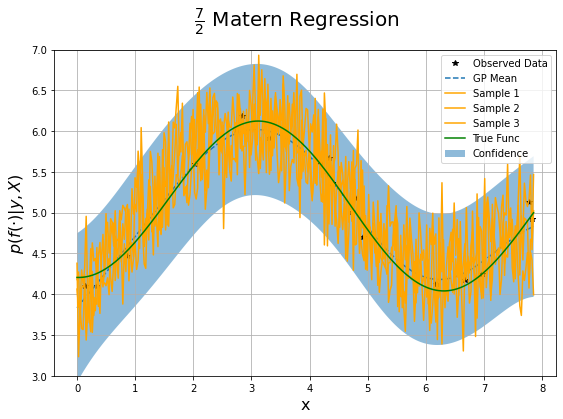

In [141]:
plot(observed_pred, train_x, train_y, true_func = u_true, y_lim = [3,7])

## Matern with boundary

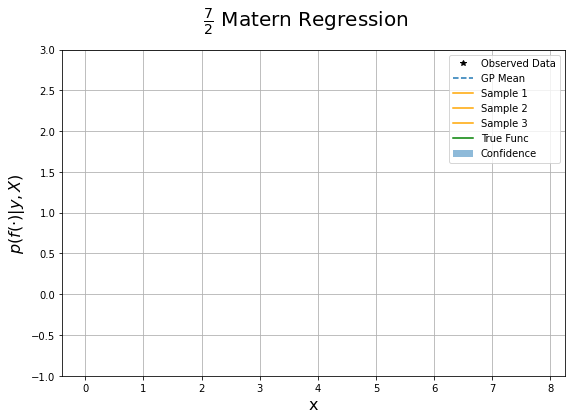

In [186]:
model2.eval()
likelihood2.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 5/2*torch.pi, 300)
    observed_pred2_clean = model2(test_x)
observed_pred2 = predict(model2, likelihood2, test_x)
plot(observed_pred2, train_x, train_y, true_func = u_true, mean_adjustment = 0, y_lim = [-1,3
                                                                                         ])

In [189]:
mll2 = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood2, model2)
metric = mll2(observed_pred2, torch.as_tensor(u_true).float())
print(metric)

tensor(0.9713, grad_fn=<DivBackward0>)


/usr/local/lib/python3.7/dist-packages/gpytorch/distributions/multivariate_normal.py:263: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  NumericalWarning,


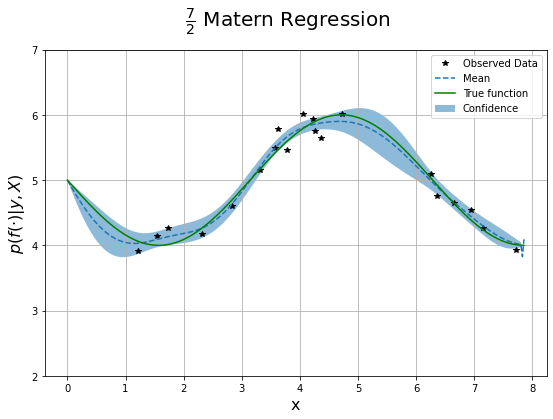

In [188]:
plot(observed_pred2_clean, train_x, train_y, true_func = u_true, y_lim = [2,7], save_name = 'boundary_const_dirichlet.png', with_samples = False)

#2-D problem

## Setup

In [ ]:
shape = (100, 100)
x, y = np.linspace(0, 1, shape[0]), np.linspace(0, 1, shape[1])
dx, dy = x[1]-x[0], y[1]-y[0]
X, Y = np.meshgrid(x, y)

L = FinDiff(0, dx, 2) + FinDiff(1, dy, 2)
f = np.zeros(shape)
# f = np.ones(shape)

bc = BoundaryConditions(shape)
bc[1,:] = FinDiff(0, dx, 1), 0  # Neumann BC
bc[-1,:] = 300. - 200*Y   # Dirichlet BC
bc[:, 0] = 300.   # Dirichlet BC
bc[1:-1, -1] = FinDiff(1, dy, 1), 0  # Neumann BC

# bc = BoundaryConditions(shape)
# bc[1,1:-2] = FinDiff(0, dy, 1), 0  # Neumann BC
# bc[-2,1:-2] = FinDiff(0, dy, 1), 0   # Neumann BC
# bc[1:-1, 1] = FinDiff(1, dx, 1), 0 # Neumann
# bc[1:-1, -2] = FinDiff(1, dx, 1), 0  # Neumann BC
# bc[:,0] = x**2


pde = PDE(L, f, bc)
# pde = PDE(L, f_sin, bc)
u = pde.solve()
# u = X**2 + Y**2

from findiff import FinDiff, Identity, PDE, BoundaryConditions
grid_size = 100
shape = (grid_size, grid_size)
dx = x[1]-x[0]
dy = y[1]-y[0]

# Set LHS
k = 1
L = k**2 * Identity() - FinDiff(0, dx, 2) - FinDiff(1, dy, 2)

# Set RHS
f = np.sin(2*X) * np.cos(2*Y)

# Set boundary conditions (zero-Dirichlet)
# bc = BoundaryConditions(shape)
# bc[0, :] = 0
# bc[-1,:] = 0
# bc[:, 0] = 0
# bc[:, -1] = 0

# Set boundary conditions (zero-Neumann)
bc = BoundaryConditions(shape)
bc[0, :] = FinDiff(0, dx, 1), 0
bc[-1,:] = FinDiff(0, dx, 1), 0
bc[:, 0] = FinDiff(1, dy, 1), 0
bc[:, -1] = FinDiff(1, dy, 1), 0

# Solve PDE
pde = PDE(L, f, bc)
u = pde.solve()

# Plot solution
plt.imshow(u, extent=[0,1,1,0])
plt.title('Ground truth field')
plt.show()

In [ ]:
for i in np.random.choice(shape[0], 10):    
    plt.plot(u[i,:])

In [ ]:
for j in np.random.choice(shape[1], 10):
    plt.plot(u[:,j])

## Converting to tensors

In [ ]:
#Choosing samples
sample_x = torch.as_tensor(np.random.choice(np.arange(0,shape[0]), size = 100))
sample_y = torch.as_tensor(np.random.choice(np.arange(0,shape[1]), size = 100))
domain_x, domain_y = torch.as_tensor(x), torch.as_tensor(y)
domain_X, domain_Y = torch.as_tensor(X), torch.as_tensor(Y)
domain_2 = torch.stack((domain_X, domain_Y))
train_x = torch.cat([domain_x[sample_x].view(-1,1), domain_y[sample_y].view(-1,1)], axis = 1).float()
u_true = torch.as_tensor(u).float()
train_y = u_true[sample_x, sample_y].float()


x = np.linspace(0,1, 100)
x1 = np.repeat(x,100)

x2 = np.tile(x,100)

xtest = np.concatenate((x1.reshape(-1,1),x2.reshape(-1,1)), axis =1)
test_x = torch.as_tensor(xtest).float()

In [ ]:
mask3 = make_rectangle((100,100), with_pad = False)

In [ ]:
test_x.shape

In [ ]:

plt.plot(solintest.eigenfun(XT))

## GP attempt

### Naive GP

In [ ]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood, is_zero_mean = True)

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()

    optimizer.step()

In [ ]:
from matplotlib import cm
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Test points
n1, n2 = 100, 100
xv, yv = torch.meshgrid([torch.linspace(0, 1, n1), torch.linspace(0, 1, n2)])


# Make predictions
with torch.no_grad(), gpytorch.settings.fast_computations(log_prob=False, covar_root_decomposition=False):
    predictions = likelihood(model(test_x))
    mean = predictions.mean

extent = (domain_X.min(), domain_X.max(), domain_Y.min(), domain_Y.max())
ax[0].imshow(u_true, extent=extent, cmap=cm.jet)
ax[0].set_title('True values')

ax[1].imshow(mean.detach().numpy().reshape(n1, n2), extent=extent, cmap=cm.jet)
ax[1].scatter(train_x[:,0], train_x[:,1])
ax[1].set_title('Predicted values')


### Boundary-Complacent GP

In [ ]:
class BCKernel2D(gpytorch.kernels.Kernel):
    def __init__(self, mask, ms = 32, neumann = [1,0,1,0], solin_dirichlet = None, solin_neumann = None, **kwargs):
        
        """
        args:
        dirichlet/neumann are lists of Boundary objects

        It allows for passing a pre-evaluated eigenfunction decomposition of the domain
        """
        super().__init__(**kwargs)

        #Only 2 dimension at the moment
        self.dimension = 2
        self.nu = torch.tensor(2.5, requires_grad = True)
        
        # self._register_nu(nu_constraint, nu_prior)
        
        # Hard coded for now!! TODO: Make more general for more dimensions
        if solin_neumann is None:
            self.solin_neumann = SolinDomain(ms = ms, mask = mask, neumann= neumann)
        else:
            self.solin_neumann = solin_neumann

        if solin_dirichlet is None:
            self.solin_dirichlet = SolinDomain(ms = ms, mask = mask, neumann = None)
        else:
            self.solin_dirichlet = solin_dirichlet
        
        self.d_eigvals, self.d_eigvecs = torch.as_tensor(self.solin_dirichlet.hlambda.copy()), self.solin_dirichlet.V

        self.n_eigvals, self.n_eigvecs = torch.as_tensor(self.solin_neumann.hlambda.copy()), self.solin_neumann.V
        

    
    # the BCkernel is not stationary and has lengthscale
    # is_stationary = True
    has_lengthscale = True

    
    def forward(self, x1, x2, **params):

        
        #Use index in order to calculate \Phi.T \Lambda (diagonal eigenvalues) \Phi (eigenvector)
        #See equation (11) in KnowYourBoundaries.pdf


        d_spec_eigvals = self._compute_spectral(self.d_eigvals, **params)
        n_spec_eigvals = self._compute_spectral(self.n_eigvals, **params)

        d_big_lambda = d_spec_eigvals*torch.eye(d_spec_eigvals.flatten().shape[0])
        n_big_lambda = n_spec_eigvals*torch.eye(d_spec_eigvals.flatten().shape[0])
        
        self.d_big_u_1 = torch.as_tensor(self.solin_dirichlet.eigenfun(x1.numpy())).type(torch.complex128)
        self.d_big_u_2 = torch.as_tensor(self.solin_dirichlet.eigenfun(x2.numpy())).type(torch.complex128)
        
        self.n_big_u_1 = torch.as_tensor(self.solin_neumann.eigenfun(x1.numpy())).type(torch.complex128)
        self.n_big_u_2 = torch.as_tensor(self.solin_neumann.eigenfun(x2.numpy())).type(torch.complex128)

        n_covar_matrix = ((self.n_big_u_1.conj() @ n_big_lambda.type(torch.complex128) @ self.n_big_u_2.T)).float()
        d_covar_matrix = ((self.d_big_u_1.conj() @ d_big_lambda.type(torch.complex128) @ self.d_big_u_2.T)).float()
        return n_covar_matrix
    
    def _compute_spectral(self, eigvals, **params):
        
        '''
        See equation (11) in KnowYourBoundaries.pdf
        '''
        d = self.dimension if torch.is_tensor(self.dimension) else torch.as_tensor(self.dimension)
        l = self.lengthscale
        v = self.nu


        log_gamma_term = torch.lgamma(v + d/2) - torch.lgamma(v)

        # const_term = 2**d * torch.pi ** (d/2) * (2*v)**v / l**(2*v)
        log_const_term = d*torch.log(torch.tensor([2])) + d/2 * torch.log(torch.tensor(torch.pi)) +  v * torch.log(2*v)  -  2*v*torch.log(l)
        
        # We take abs eigvals because the eigenvalues are meant to be positive if we had done the 
        # Negative laplacian instead of the laplacian as the matrix
        foo = (2*v/torch.pow(l,2) + torch.abs(eigvals))

        spectral = torch.exp(log_gamma_term + log_const_term ) * torch.pow((foo), -(2*v+d)/2)
        return spectral
    


In [ ]:
bc_k = BCKernel2D(mask3, ms = 32, neumann = [0,1,1,0])
solin_dirichlet = bc_k.solin_dirichlet
solin_neumann = bc_k.solin_neumann
bc_k = BCKernel2D(mask3, 32, solin_neumann = solin_neumann, solin_dirichlet = solin_dirichlet)
likelihood2 = gpytorch.likelihoods.GaussianLikelihood()
model2 = ExactGPModel(train_x, train_y, likelihood2, kernel = bc_k, has_mean_adjustment = False)

print("-----------------------INITIAL PARAMS-------------------------")
for param_name, param in model2.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

print("--------------------------------------------------------------")
model2.train()
likelihood2.train()
train(model2, train_x, train_y, likelihood2, verbose = True)

print("----------------------TRAINED PARAMS----------------------------")
for param_name, param in model2.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')
print("-----------------------------------------------------------------")

In [ ]:
%debug

In [ ]:
from matplotlib import cm
# Set into eval mode
model2.eval()
likelihood2.eval()

shape = mask3.shape

# Initialize plots
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Test points
n1, n2 = shape[0], shape[1]
xv, yv = torch.meshgrid([torch.linspace(0, 1, n1), torch.linspace(0, 1, n2)])
u_true


# Make predictions
with torch.no_grad(), gpytorch.settings.fast_computations(log_prob=False, covar_root_decomposition=False):
    test_x = torch.stack([xv.reshape(shape[0]*shape[1], 1), yv.reshape(shape[0]*shape[1], 1)], -1).squeeze(1)
    predictions = likelihood2(model2(test_x))
    mean = predictions.mean

extent = (domain_X.min(), domain_X.max(), domain_Y.min(), domain_Y.max())
ax[0].imshow(u_true, extent=extent, cmap=cm.jet)
ax[0].set_title('True values')

ax[1].imshow(mean.detach().numpy().reshape(n1, n2), extent=extent, cmap=cm.jet)
ax[1].set_title('Predicted values')


In [ ]:
u_true.reshape(n1,n2)

In [ ]:
plt.plot(solin_neumann.V[:,0])

In [ ]:
solin_neumann.V.shape

In [ ]:
likelihood2 = gpytorch.likelihoods.GaussianLikelihood()
neumann_x = Boundary('neumann', [[0, slice(None)], [2, slice(None)]])
neumann_y = Boundary('neumann', indices = [[slice(None), shape[1] - 1], [slice(None,), shape[1] -3]])

constant_x = np.ones(shape[0]) * 300
constant_y = 300 - 200*domain_y
dirichlet = Boundary('dirichelt', indices = [[shape[0], slice(None)], [slice(None,), 0]], 
                     constants = [constant_x, constant_y])

bc_k = BCKernel(domain = domain_2, dirichlet = [dirichlet,], neumann = [neumann_x, neumann_y], likelihood = likelihood2, big_domain = big_domain)
bc_kernel = gpytorch.kernels.ScaleKernel(bc_k)
mean_adjustment = bc_k.mean_adjustment
gp_mean = KernelMean(mean_adjustment, domain)
# bc_kernel = gpytorch.kernels.ScaleKernel(BCKernel(domain = domain, neumann = [neumann_test,], likelihood = likelihood2, big_domain = big_domain))
model2 = ExactGPModel(train_x, train_y, likelihood2, kernel = bc_kernel, mean = gp_mean)

# model2.covar_module = gpytorch.kernels.ScaleKernel(BCKernel(domain = domain, neumann = [neumann_test,], likelihood = likelihood2, big_domain = big_domain))
# model2.covar_module = gpytorch.kernels.ScaleKernel(BCKernel(domain = domain, likelihood = likelihood2, big_domain = big_domain))
# model2.covar_module = BCKernel(domain = domain, likelihood = likelihood2, big_domain = big_domain)

print("-----------------------INITIAL PARAMS-------------------------")
for param_name, param in model2.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

print("--------------------------------------------------------------")
model2.train()
likelihood2.train()
train(model2, train_x, train_y, likelihood2, verbose = True)

print("----------------------TRAINED PARAMS----------------------------")
for param_name, param in model2.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')
print("-----------------------------------------------------------------")

#Benchmarking

In [ ]:
'''
Define the test problem below
'''

class Problem:
    def __init__(self):
        self.shape = (300, )
        self.t = np.linspace(0, 10, self.shape[0])
        t = self.t
        shape = self.shape
        self.dt = t[1]-t[0]
        dt = self.dt

        ALPHA = 3
        OMEGA = 2
        LAMBDA = 0

        laplace_1d = FinDiff(0,dt,2)

        f = np.sin(t)

        #Add some boundary conditions
        bc = BoundaryConditions(shape)
        bc[-1] = 0
        bc[1] = FinDiff(0, dt, 1), 0


        #Solve the PDE using a solver (although I would have assumed the answer to just be -np.sin(t))
        pde = PDE(laplace_1d, f, bc)
        #Store the solution in u_true
        self.u_true = pde.solve()

        self.y = self.u_true + 0.2*np.random.normal(size = shape)

        #Choosing samples
        sample_indices = np.random.choice(np.arange(0,shape[0]), size = 20)
        # sample_indices = np.arange(50)
        self.train_x = torch.Tensor(t[sample_indices])
        # True function is -sin(x) with Gaussian noise? I wouldve assumed
        self.test_y = y
        self.train_y = torch.Tensor(self.y[sample_indices])

        self.domain = torch.linspace(0, 10, shape[0])
        self.big_domain = make_big_d(0,10,shape[0])

    def train_boundary(self):
        domain = self.domain
        big_domain = self.big_domain
        train_y = self.train_y
        train_x = self.train_x
        
        likelihood2 = gpytorch.likelihoods.GaussianLikelihood()
        neumann_test = Boundary('neumann', [[0], [2]])
        dirichlet_test = Boundary('dirichlet', [1, self.shape[0]], constants = [0, -torch.sin(torch.tensor(self.t[-1]))])
        # dirichlet_test = Boundary('dirichlet', [0, shape[0] -1], constants = [0, 0])

        bc_kernel = BCKernel(domain = domain, dirichlet = None, neumann = [neumann_test,], likelihood = likelihood2, big_domain = big_domain)
        gp_mean = KernelMean(domain)
        # bc_kernel = gpytorch.kernels.ScaleKernel(BCKernel(domain = domain, neumann = [neumann_test,], likelihood = likelihood2, big_domain = big_domain))
        model2 = ExactGPModel(train_x, train_y, likelihood2, kernel = bc_kernel, mean = gp_mean)

        print("-----------------------INITIAL PARAMS-------------------------")
        for param_name, param in model2.named_parameters():
            print(f'Parameter name: {param_name:42} value = {param.item()}')

        print("--------------------------------------------------------------")
        model2.train()
        likelihood2.train()
        train(model2, train_x, train_y, likelihood2, verbose = True)

        print("----------------------TRAINED PARAMS----------------------------")
        for param_name, param in model2.named_parameters():
            print(f'Parameter name: {param_name:42} value = {param.item()}')
        print("-----------------------------------------------------------------")


        self.model_boundary = model2
        self.likelihood_boundary = likelihood2
    def eval_boundary(self):
        model2 = self.model_boundary
        likelihood2 = self.likelihood_boundary
        model2.eval()
        likelihood2.eval()
        
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            test_x = torch.linspace(0, 10, 300)
            observed_pred2 = model2(test_x)
        self.pred_boundary_clean = model2(test_x)
        self.pred_boundary_noise = predict(model2, likelihood2, test_x)
    
    def plot(self, predictions):
        plot(predictions, self.train_x, self.train_y, true_func = self.u_true, y_lim = [-15,5])

    def train_naive(self):
        domain = self.domain
        big_domain = self.big_domain
        train_y = self.train_y
        train_x = self.train_x

        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        model = ExactGPModel(train_x, train_y, likelihood, is_zero_mean = True)
        model.train()
        likelihood.train()
        train(model, train_x, train_y, likelihood, verbose = True)
        print("----------------------TRAINED PARAMS----------------------------")
        for param_name, param in model.named_parameters():
            print(f'Parameter name: {param_name:42} value = {param.item()}')
        print("-----------------------------------------------------------------")
        self.naive_model = model
        self.naive_likelihood = likelihood

    def eval_naive(self):
        model = self.naive_model
        likelihood = self.naive_likelihood
        
        model.eval()
        likelihood.eval()
        # Test points are regularly spaced along [0,1]
        # Make predictions by feeding model through likelihood
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            test_x = torch.linspace(0, 10, 300)
            self.naive_pred_noise = likelihood(model(test_x))
            self.naive_pred_clean = model(test_x)
    


In [ ]:
prob = Problem()
prob.train_boundary()
prob.train_naive()
prob.eval_boundary()
prob.eval_naive()
prob.plot(prob.pred_boundary_clean)

In [ ]:
prob.plot(prob.naive_pred_clean)

In [ ]:
%debug

#Debug Playground

In [ ]:
debug_mean

 A = 5 x 5
 [1 0 0 0 0]          u[0]
 [1 -2 1 0 0]         u[1]
 [0 1 -2 1 0]    @    u[2]     =     λ u
 [0 0 1 -2 1]         u[3]
 [0 0 0 0 1]          u[4]


We have found u, λ such that for:
B = 3 x 3
[-2 1 0]             u[1]
[1 -2 1]      @      u[2]   = λ u
[0 1 -2]             u[3]

Now, we want to find u such that when u[0] = a, it is a point on the eigenvector of C:

C = 4 x 4
[1 0  0 0]             u[0] = a                   a
[1 -2 1 0]             u[1]                       λu[1] + a
[0 1 -2 1]      @      u[2]              --->     λu[2]
[0 0 1 -2]             u[3]                       λu[3]



[1 0 0 0 0]           u[0]
 [1 -2 1 0 0]         u[1]
 [0 1 -2 1 0]    @    u[2]     =     λ u
 [0 0 1 -2 1]         u[3]
 [0 0 0 0 1]          u[4]

u[0] - 2u[1] + u[2] = λ u[0]
u[1] - 2u[2] + u[3] = λ u[1]
...


 B = A[1:,1:]
 B = 2 x 2

Eigenvectors of B:
 [u2, u3], [k2, k3]

Proposed eigenvectors of A that satisfy u1 = 3
 u_new : [u1 = 3, u2, u3], k_new : [k1 = 3, k2, k3]

Also needs to satisfy
A @ u_new = lambda * u_new 

for eigenvecs_b of B:
    let u_new = [0 , eigenvecs[b]]
    if A @ u_new = lambda * u_new:
        append u_new as correct eigenvec


A b = lambda b 
(A - lambda I) b= 0

(A - lambda I)^-1 0 = b

In [ ]:
print(eigenvectors.shape)
print(eigenvectors.type())

plt.plot(torch.real(eigenvectors[:10, 0]))
a = 20
# print(eigenvectors[0,a])
# print((eigenvectors[0,a] - eigenvectors[2,a] == 0).all())
# for i in range(a):
#     print(eigenvectors[0,a])
#     print(eigenvectors[-1,a])



print((torch.real(eigenvectors[0,:]) == 0).all())
print((torch.real(eigenvectors[-1,:]) == np.sin(t[-1])).all())

In [ ]:
print(dirichlet_test.right_vec.shape)

In [ ]:
a = torch.rand((4,1))
b = torch.rand((4,1))
c = torch.cat((a,b), axis = 1)
c.shape

#Normal vector

In [ ]:
import numpy
import dolfin
from dolfin import *


def mesh_to_boundary(v, b_mesh):
    """
    Returns a the boundary representation of the CG-1 function v
    """
    # Extract the underlying volume and boundary meshes
    mesh = v.function_space().mesh()

    # We use a Dof->Vertex mapping to create a global
    # array with all DOF values ordered by mesh vertices
    DofToVert = dolfin.dof_to_vertex_map(v.function_space())
    VGlobal = numpy.zeros(v.vector().size())

    vec = v.vector().get_local()
    for i in range(len(vec)):
        Vert = dolfin.MeshEntity(mesh, 0, DofToVert[i])
        globalIndex = Vert.global_index()
        VGlobal[globalIndex] = vec[i]
    VGlobal = SyncSum(VGlobal)

    # Use the inverse mapping to se the DOF values of a boundary
    # function
    surface_space = dolfin.FunctionSpace(b_mesh, "CG", 1)
    surface_function = dolfin.Function(surface_space)
    mapa = b_mesh.entity_map(0)
    DofToVert = dolfin.dof_to_vertex_map(dolfin.FunctionSpace(b_mesh, "CG", 1))

    LocValues = surface_function.vector().get_local()
    for i in range(len(LocValues)):
        VolVert = dolfin.MeshEntity(mesh, 0, mapa[int(DofToVert[i])])
        GlobalIndex = VolVert.global_index()
        LocValues[i] = VGlobal[GlobalIndex]

    surface_function.vector().set_local(LocValues)
    surface_function.vector().apply('')
    return surface_function

def vector_mesh_to_boundary(func, b_mesh):
    v_split = func.split(deepcopy=True)
    v_b = []
    for v in v_split:
        v_b.append(mesh_to_boundary(v, b_mesh))
    Vb = dolfin.VectorFunctionSpace(b_mesh, "CG", 1)
    vb_out = dolfin.Function(Vb)
    scalar_to_vec = dolfin.FunctionAssigner(Vb, [v.function_space() for
                                                  v in v_b])
    scalar_to_vec.assign(vb_out, v_b)
    return vb_out


def SyncSum(vec):
    """ Returns sum of vec over all mpi processes.
    Each vec vector must have the same dimension for each MPI process """

    comm = dolfin.MPI.comm_world
    NormalsAllProcs = numpy.zeros(comm.Get_size() * len(vec), dtype=vec.dtype)
    comm.Allgather(vec, NormalsAllProcs)

    out = numpy.zeros(len(vec))
    for j in range(comm.Get_size()):
        out += NormalsAllProcs[len(vec) * j:len(vec) * (j + 1)]
    return out

def boundary_to_mesh(f, mesh):
    b_mesh = f.function_space().mesh()
    SpaceV = dolfin.FunctionSpace(mesh, "CG", 1)
    SpaceB = dolfin.FunctionSpace(b_mesh, "CG", 1)

    F = dolfin.Function(SpaceV)
    GValues = numpy.zeros(F.vector().size())

    map = b_mesh.entity_map(0)  # Vertex map from boundary mesh to parent mesh
    d2v = dolfin.dof_to_vertex_map(SpaceB)
    v2d = dolfin.vertex_to_dof_map(SpaceV)

    dof = SpaceV.dofmap()
    imin, imax = dof.ownership_range()

    for i in range(f.vector().local_size()):
        GVertID = dolfin.Vertex(b_mesh, d2v[i]).index()  # Local Vertex ID for given dof on boundary mesh
        PVertID = map[GVertID]  # Local Vertex ID of parent mesh
        PDof = v2d[PVertID]  # Dof on parent mesh
        value = f.vector()[i]  # Value on local processor
        GValues[dof.local_to_global_index(PDof)] = value
    GValues = SyncSum(GValues)

    F.vector().set_local(GValues[imin:imax])
    F.vector().apply("")
    return F


mesh = Mesh(UnitDiscMesh.create(MPI.comm_world, 100, 1, 2))
n = FacetNormal(mesh)
V = VectorFunctionSpace(mesh, "CG", 1)
u = TrialFunction(V)
v = TestFunction(V)
a = inner(u,v)*ds
l = inner(n, v)*ds
A = assemble(a, keep_diagonal=True)
L = assemble(l)

A.ident_zeros()
nh = Function(V)

solve(A, nh.vector(), L)
File("nh.pvd") << nh
bmesh = BoundaryMesh(mesh, "exterior")
nb = vector_mesh_to_boundary(nh, bmesh)
Q = FunctionSpace(bmesh, "CG", 1)

p, q = TrialFunction(Q), TestFunction(Q)
a = inner(p,q)*dx
l = inner(div(nb), q)*dx
A = assemble(a, keep_diagonal=True)
L = assemble(l)
A.ident_zeros()
kappab = Function(Q)
solve(A, kappab.vector(), L)
kappa = boundary_to_mesh(kappab, mesh)

print(assemble(kappa*ds))
File("kappa.pvd") << kappa

In [ ]:
""" ---------------------------------- START SEARCH FOR NEUMANN RELATED INDICES -----------------------------------------"""
intR_dyt, intR_dxl, intC_dyt, intC_dxl, intR_dyb, intR_dxr, intC_dyb, intC_dxr = find_interior(I,J)
row_int = np.array([])
col_int = np.array([])
row_ext = np.array([])
col_ext = np.array([])

extR_dyt, extC_dyt = find_exterior(intR_dyt, intC_dyt, np.array([2,0]));
extR_dyb, extC_dyb = find_exterior(intR_dyb, intC_dyb, np.array([-2,0]));
extR_dxl, extC_dxl = find_exterior(intR_dxl, intC_dxl, np.array([0,-2]));
extR_dxr, extC_dxr = find_exterior(intR_dxr, intC_dyb, np.array([0,2]));

if neumann[0] == 1:
    row_int = np.append(row_int, intR_dxl)
    row_ext = np.append(row_ext, extR_dxl)
    col_int = np.append(col_int, intC_dxl)
    col_ext = np.append(col_ext, extC_dxl)

if neumann[1] == 1:
    row_int = np.append(row_int, intR_dxr)
    row_ext = np.append(row_ext, extR_dxr)
    col_int = np.append(col_int, intC_dxr)
    col_ext = np.append(col_ext, extC_dxr)

if neumann[2] == 1:
    row_int = np.append(row_int, intR_dyt)
    row_ext = np.append(row_ext, extR_dyt)
    col_int = np.append(col_int, intC_dyt)
    col_ext = np.append(col_ext, extC_dyt)

if neumann[3] == 1:
    row_int = np.append(row_int, intR_dyb)
    row_ext = np.append(row_ext, extR_dyb)
    col_int = np.append(col_int, intC_dyb)
    col_ext = np.append(col_ext, extC_dyb)

row_len = self.mask.shape[0]
""" ---------------------------------- END SEARCH FOR NEUMANN RELATED INDICES -----------------------------------------"""

def find_interior(rows_of_ones, cols_of_ones):
    I = rows_of_ones
    J = cols_of_ones
    n = len(I)
    m = len(J)
    firstNeighboursRow = [0, 0, -1, 1];
    firstNeighboursCol = [-1, 1, 0, 0];
    
    secondNeighboursRow = [0, 0, -2, 2];
    secondNeighboursCol = [-2, 2, 0, 0];

    def inBounds (r:int, c : int):
        if 0 <= r and r < n and 0 <= c and c < m:
            return True
        return False
    
    def checkNeighbours (r :int, c :int, args):
        intR_dyt, intR_dxl, intC_dyt, intC_dxl, intR_dyb, intR_dxr, intC_dyb, intC_dxr = args
        #check first neighbours
        nrF = 0
        for i in range (0, 4):
            R = r + firstNeighboursRow[i]
            C = c + firstNeighboursCol[i]
            if inBounds(R, C) and np.where((I == R) & (J == C))[0].size>0:
                nrF = nrF + 1
        if nrF < 4:
            return args
        #check second neighbours
        nrS = 0
        for i in range (0, 4):
            R = r + secondNeighboursRow[i]
            C = c + secondNeighboursCol[i]
            if inBounds(R, C):
                if not (np.where((I == R) & (J == C))[0].size > 0):
                    #We are at the interior with respect to a movement in the row
                    if i == 0:
                        intR_dyb = np.append(intR_dyb, r)
                        intC_dyb = np.append(intC_dyb, c)
                    #We are at the interior with respect to a movement in the column
                    elif i == 1:
                        intR_dyt = np.append(intR_dyt, r)
                        intC_dyt = np.append(intC_dyt, c)
                    elif i == 2:
                        intR_dxl = np.append(intR_dxl, r)
                        intC_dxl = np.append(intC_dxl, c)
                    elif i == 3:
                        intR_dxr = np.append(intR_dxr, r)
                        intC_dxr = np.append(intC_dxr, c)
        return intR_dyt, intR_dxl, intC_dyt, intC_dxl, intR_dyb, intR_dxr, intC_dyb, intC_dxr
    
    #rows and columns corresponding to the interior

    #Top-Row for dy direction 
    intR_dyt = np.array([])
    #Left-Row for dx direction
    intR_dxl = np.array([])
    #Top-Column for dy direction
    intC_dyt = np.array([])
    #Left-Column for dx direction
    intC_dxl = np.array([])
    #Bottom-Row for dy direction
    intR_dyb = np.array([])
    intR_dxr = np.array([])
    intC_dyb = np.array([])
    intC_dyr = np.array([])
    
    args = [intR_dyt, intR_dxl, intC_dyt, intC_dxl, intR_dyb, intR_dxr, intC_dyb, intC_dyr]
    for i,j in zip(I,J):
        intR_dyt, intR_dxl, intC_dyt, intC_dxl, intR_dyb, intR_dxr, intC_dyb, intC_dyr = checkNeighbours(i, j , args)
        args = [intR_dyt, intR_dxl, intC_dyt, intC_dxl, intR_dyb, intR_dxr, intC_dyb, intC_dyr]
    return args

def convert_to_index(row_arr, col_arr, row_len):
    return col_arr +  row_len * (row_arr)

def find_exterior(row_int, col_int, direction = np.array([0, 0])):
    return row_int + direction[0], col_int + direction[1]